<a href="https://colab.research.google.com/github/nferrucho/NPL/blob/main/curso2/ciclo5/Copia_de_M5U5_Taller_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "https://drive.google.com/uc?export=view&id=1Hh_G3M13P9xSNgSiQ-WnALg93XwK_hG8" alt = "Encabezado MLDS" width = "100%">  </img>

# **Tarea 5 - _Autoencoders_ Variacionales**
---

El objetivo de esta tarea es adquirir experiencia práctica en la implementación y el entrenamiento de _autoencoders_ variacionales en un conjunto de datos de rostros humanos. La tarea consistirá en preprocesar los datos, construir un modelo VAE, entrenar el modelo y visualizar los resultados.

Importemos las librerías requeridas para solucionar la tarea:

> **Importante:  Recomendamos utilizar GPU para la ejecución de este notebook, ya que puede tomar mucho tiempo la ejeución de algunos casos de prueba en caso de que no se utilice.**

In [1]:
!pip install rlxcrypt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.9/297.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.0 MB/s eta 0:00:00
  Created wheel for imphook: filename=imphook-1.0-py3-none-any.whl size=9423 sha256=fd97cb69b9b95b308df1a0768af6a3f16ac4038dd14f8263dd91cb1a94d426b0
  Stored in directory: /root/.cache/pip/wheels/dc/e2/a4/fcb3817d09a2eb047b2b08eb58e7d9140041b0f3f415eb1256
Successfully built imphook


In [2]:
!wget --no-cache -O session.pye -q https://raw.githubusercontent.com/JuezUN/INGInious/master/external%20libs/session.pye

In [5]:
import rlxcrypt
import session

grader = session.LoginSequence("DLIAAPCP-GroupMLDS-5-2024-2@b0a95b9d-ce8e-4169-a2c2-91c500611fc6")

Please enter your UNCode username: nelson.ferrucho@gmail.com
Please enter your password: ··········


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from PIL import Image

In [7]:
# Versiones de las librerías usadas.
!python --version
print('Numpy', np.__version__)
print('Tensorflow', tf.__version__)

Python 3.10.12
Numpy 1.26.4
Tensorflow 2.17.0


Esta actividad se diseñó con las siguientes versiones:
*  Python 3.10.16
*  Numpy 1.22.4
*  Tensorflow 2.12.0

> **Importante:  Recomendamos utilizar GPU para la ejecución de este notebook, ya que puede tomar mucho tiempo la ejecución de algunos casos de prueba en caso de que no se utilice.**

# **Cargar Datos**
---
El conjunto de datos [Olivetti Faces](https://scikit-learn.org/0.19/datasets/olivetti_faces.html) es adecuado para esta tarea, ya que consta de 400 imágenes de rostros con diversos atributos (ojos abiertos/cerrados, sonriente/no sonriente, gafas/no gafas, etc).
Vamos a descargar el dataset en el entorno de Colab usando _Scikit Learn_:

In [28]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(shuffle = True, random_state= 55)
X, y = faces.data, faces.target
X = X.reshape(400,64,64,1)
print(faces.DESCR)
print("Tamaño de X =",X.shape)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

Las imágenes están almacenmadas como un `np.array` de tamaño `(400,64,64,1)`. Cada fotografía es de tamaño $64\times64$, y tiene un solo canal, es decir, cada imagen consta de 4096 pixeles, con valores entre $0$ y $1$. Vamos entonces a visualizar algunas de estas imágenes:

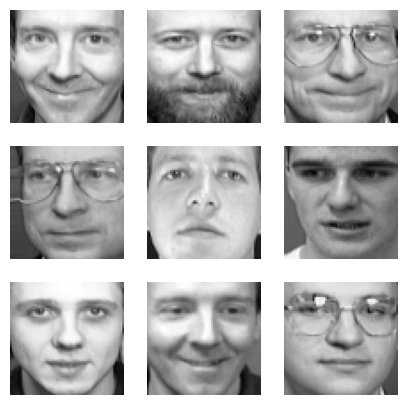

In [9]:
num_images=9
# Select the first num_images files
selected_files = X[:num_images]
# Load and store images in a list
images = [file for file in selected_files]
# Calculate the size of the grid
grid_size = int(num_images ** 0.5)
# Create a subplot for each image
fig, axes = plt.subplots(grid_size, grid_size, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i], cmap = 'gray')
    ax.axis("off")
plt.show()

> **La tarea es incremental, por lo tanto es recomendable resolver los puntos en orden.**

# **1. _Data Generator_**
---

Complete la función `data_generator` que crea conjuntos de datos de entrenamiento y prueba a partir de un conjunto de imágenes `X`. La función dividirá las imágenes en conjuntos de entrenamiento y prueba y creará conjuntos de datos de TensorFlow con un tamaño de _batch_ especificado.

**Entrada**:

* **`X`**: `np.array`, un arreglo de NumPy que contiene las imágenes.
* **`test_size`**: `float`, la proporción de imágenes que se deben asignar al conjunto de prueba (por ejemplo, 0.2 para el 20%).
* **`batch_size`**: `int`, el tamaño del _batch_ para los conjuntos de datos de entrenamiento y prueba.

**Salida**:

* **`train_dataset`**: `tf.data.Dataset`, un conjunto de datos de TensorFlow para entrenamiento.
* **`test_dataset`**: `tf.data.Dataset`, un conjunto de datos de TensorFlow para prueba.

> **Notas**:
* Utilice `train_test_split` de `sklearn` para dividir las imágenes en conjuntos de entrenamiento y prueba con la proporción especificada en `test_size`. **Además**, fije la semilla aleatoria con **`random_state=42`**.
* Cree un conjunto de datos de TensorFlow `train_dataset` a partir del conjunto de entrenamiento usando `tf.data.Dataset.from_tensor_slices`.
* Mezcle y divida en _batches_ el `train_dataset` usando la función `shuffle` y el `batch_size` especificado.
* Cree un conjunto de datos de TensorFlow `test_dataset` a partir del conjunto de prueba usando `tf.data.Dataset.from_tensor_slices`.
* Mezcle y divida en _batches_ el `test_dataset` usando la función `shuffle` y el `batch_size` especificado.

In [27]:
# FUNCIÓN CALIFICADA data_generator

def data_generator(X, test_size, batch_size):
    # Fijamos una semilla para efectos de reproducibiidad
    np.random.seed(0)
    tf.keras.utils.set_random_seed(0)

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test = train_test_split(X, test_size=test_size, random_state=42)

    # Crear el conjunto de datos de entrenamiento de TensorFlow
    train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
    train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size)

    # Crear el conjunto de datos de prueba de TensorFlow
    test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
    test_dataset = test_dataset.shuffle(buffer_size=1000).batch(batch_size)

    return train_dataset, test_dataset

Tamaño del batch = 32
Primeras cuatro imágenes


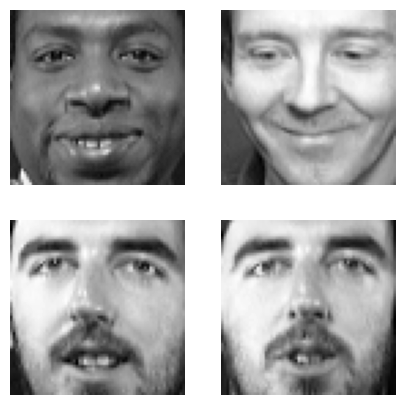

In [31]:
# TEST_CELL
X_train, X_test = data_generator(X, test_size=0.01, batch_size=32)
dataset = X_train.batch(1)
print('Tamaño del batch =', list(dataset.as_numpy_iterator())[0].shape[1])
ims = list(dataset.as_numpy_iterator())[0][0]
plt.figure(figsize=(5, 5))
# Mostramos 4 ejemplos
print("Primeras cuatro imágenes")
for i in range(4):
    plt.subplot(221+i)
    plt.imshow(ims[i], cmap='gray')
    plt.axis("off")

**Salida esperada**:
```
Tamaño del batch = 32
Primeras cuatro imágenes
```
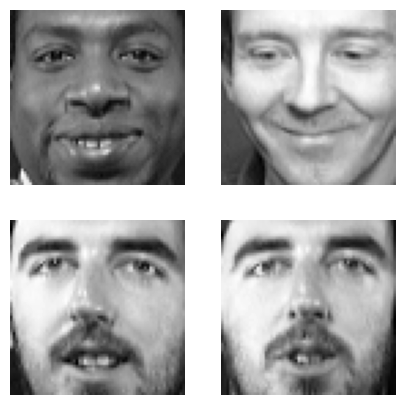

### **Evaluar código**

In [ ]:
grader.run_test("Test 1_1", globals())

Test 1_1


In [ ]:
grader.run_test("Test 1_2", globals())

Test 1_2


# **2. Codificador**
---
Complete la función `build_encoder` para que construya un codificador de red neuronal. El codificador deberá tomar imágenes de entrada de tamaño `64x64x1` y producir dos vectores de dimensión `latent_dim`: `z_mean` y `z_log_var`.

**Entrada**:

* **`latent_dim`**: `int`, la dimensión del espacio latente.

**Salida**:

* **`encoder`**: `tf.keras.Model`, un modelo de _TensorFlow_ que representa el codificador.

> **Notas**:
  * Crear una entrada de modelo con tamaño `(64, 64, 1)`.
  * Añadir una capa `Conv2D` con `16` filtros, kernel de tamaño `(5, 5)`, strides `(2, 2)`, padding `"same"` y función de activación `"relu"`. Conecte esta capa a las entradas.
  * Añadir una capa `Conv2D` con `32` filtros, kernel de tamaño `(3, 3)`, strides `(2, 2)`, padding `"same"` y función de activación `"relu"`. Conecte esta capa a la capa anterior.
  * Añadir otra capa `Conv2D` con `64` filtros, kernel de tamaño `(3, 3)`, strides `(2, 2)`, padding `"same"` y función de activación `"relu"`. Conecte esta capa a la capa anterior.
  * Añadir una cuarta capa `Conv2D` con `128` filtros, kernel de tamaño `(3, 3)`, strides `(2, 2)`, padding `"same"` y función de activación `"relu"`. Conecte esta capa a la capa anterior.
  * Aplique una capa `Flatten` a la salida de la cuarta capa Conv2D.
  * Crear dos capas `Dense` separadas, con `latent_dim` unidades cada una. Conecte ambas capas a la salida de la capa `Flatten` anterior. Estas capas representarán `z_mean` y `z_log_var`.






In [29]:
# FUNCIÓN CALIFICADA build_encoder
def build_encoder(latent_dim):

    inputs = tf.keras.layers.Input(shape=(64, 64, 1))

    # Primera capa Conv2D
    x = tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(2, 2), padding="same", activation="relu")(inputs)

    # Segunda capa Conv2D
    x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(x)

    # Tercera capa Conv2D
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(x)

    # Cuarta capa Conv2D
    x = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(x)

    # Capa Flatten
    x = tf.keras.layers.Flatten()(x)

    # Capa Dense para z_mean
    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)

    # Capa Dense para z_log_var
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)


    encoder = tf.keras.models.Model(inputs, outputs=[z_mean, z_log_var])
    return encoder


In [30]:
# TEST_CELL
encoder_test = build_encoder(latent_dim=100)
encoder_test.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 64, 64, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 16)     │            416 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 32)     │          4,640 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2048)           │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 100)            │        204,900 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 100)            │        204,900 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 507,208 (1.93 MB)

 Trainable params: 507,208 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

**Salida esperada**:
```
Model: "functional"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 16)     │            416 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 32)     │          4,640 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2048)           │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 100)            │        204,900 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 100)            │        204,900 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘
 Total params: 507,208 (1.93 MB)
 Trainable params: 507,208 (1.93 MB)
 Non-trainable params: 0 (0.00 B)
```

### **Evaluar código**

In [ ]:
grader.run_test("Test 2_1", globals())

Test 2_1


In [ ]:
grader.run_test("Test 2_2", globals())

Test 2_2


# **3. Decodificador**
---
Complete la función `build_decoder` que construye un decodificador. El decodificador deberá tomar un vector de dimensión `latent_dim` como entrada y producir una imagen de salida de tamaño `64x64x1`.

**Entrada**:

* **`latent_dim`**: `int`, la dimensión del espacio latente.

**Salida**:

* **`decoder`**: `tf.keras.Model`, un modelo que representa el decodificador.

> **Notas**:
* Crear una entrada de tamaño `latent_dim`.
* Añadir una capa `Dense` con `4 * 4 * 128` unidades y función de activación `"relu"`. Conecte esta capa a las entradas.
* Aplique una capa `Reshape` a la salida de la capa `Dense` para convertir el tensor en una forma de `(4, 4, 128)`.
* Añadir una capa `Conv2DTranspose` con `128` filtros, kernel de tamaño `(3, 3)`, strides `(2, 2)`, padding `"same"` y función de activación `"relu"`. Conecte esta capa a la capa `Reshape`.
* Añadir otra capa `Conv2DTranspose` con `64` filtros, kernel de tamaño `(3, 3)`, strides `(2, 2)`, padding `"same"` y función de activación `"relu"`. Conecte esta capa a la capa anterior.
* Añadir una tercera capa `Conv2DTranspose` con `32` filtros, kernel de tamaño `(3, 3)`, strides `(2, 2)`, padding `"same"` y función de activación `"relu"`. Conecte esta capa a la capa anterior.
* Añadir una cuarta capa `Conv2DTranspose` con `16` filtros, kernel de tamaño `(5, 5)`, strides `(2, 2)`, padding `"same"` y función de activación `"relu"`. Conecte esta capa a la capa anterior.
* Añadir una última capa `Conv2DTranspose` con `1` filtro, kernel de tamaño `(3, 3)`, padding `"same"`, **sin función de activación**. Conecte esta capa a la salida de la tercera capa `Conv2DTranspose`.


In [32]:
# FUNCIÓN CALIFICADA build_decoder
def build_decoder(latent_dim):
    inputs = tf.keras.layers.Input(shape=(latent_dim,))

    # Capa Dense - Use tf.keras.layers.Dense instead of tf.keras.Dense
    x = tf.keras.layers.Dense(4 * 4 * 128, activation="relu")(inputs)

    # Capa Reshape para convertir el tensor en (4, 4, 128)
    x = tf.keras.layers.Reshape((4, 4, 128))(x)

    # Primera capa Conv2DTranspose
    x = tf.keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(x)

    # Segunda capa Conv2DTranspose
    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(x)

    # Tercera capa Conv2DTranspose
    x = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(x)

    # Cuarta capa Conv2DTranspose
    x = tf.keras.layers.Conv2DTranspose(16, kernel_size=(5, 5), strides=(2, 2), padding="same", activation="relu")(x)

    # Última capa Conv2DTranspose para obtener la imagen de salida
    x = tf.keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), padding="same")(x)

    decoder = tf.keras.models.Model(inputs, outputs=x)
    return decoder

In [33]:
# TEST_CELL
decoder_test = build_decoder(latent_dim=100)
decoder_test.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2048)                │         206,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 64, 64, 16)          │          12,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 64, 64, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 459,649 (1.75 MB)

 Trainable params: 459,649 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

**Salida esperada**:
```
Model: "functional_1"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 2048)                │         206,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 16)          │          12,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘
 Total params: 459,649 (1.75 MB)
 Trainable params: 459,649 (1.75 MB)
 Non-trainable params: 0 (0.00 B)
```

### **Evaluar código**

In [ ]:
grader.run_test("Test 3_1", globals())

Test 3_1


In [ ]:
grader.run_test("Test 3_2", globals())

Test 3_2


# **Funciones para trabajar con distribuciones normales en modelos generativos**

En el desarrollo de lo que queda de la tarea, es muy probable y recomendable que necesite usar las siguientes funciones:

In [34]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)

    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def reparameterize(mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

Estas son las mismas funciones que se usan en el taller guiado sobre _autoencoders_ variacionales. Recordemos para qué sirven:

**`log_normal_pdf`**

La función `log_normal_pdf` recibe tres parámetros: `sample`, `mean`, `logvar` y un parámetro opcional llamado `raxis`. Los parámetros `mean` y `logvar` son la media y la log-varianza de la distribución normal multivariante, respectivamente. El parámetro `sample` es una muestra de la distribución normal multivariante que se desea evaluar.

En pocas palabras, la función calcula el logaritmo de la probabilidad de que `sample` haya sido generado por una distribución normal multivariante con media `mean` y log-varianza `logvar`.

**`reparameterize`**

Esta función permite obtener una muestra aleatoria de una distribución normal multivariante a partir de su media y log-varianza mediante la técnica de reparameterización. `reparameterize` recibe dos parámetros: `mean` y `logvar`. La idea de la reparameterización es muestrear una variable aleatoria de una distribución parametrizada por `mean` y `logvar` mediante una transformación determinista. En este caso, la transformación utilizada es la siguiente:

```python
eps = tf.random.normal(shape=mean.shape)
z = eps * tf.exp(logvar * .5) + mean
```

La variable `eps` es una muestra aleatoria de una distribución normal estándar y `z` es la muestra aleatoria de la distribución normal multivariante parametrizada por `mean` y `logvar`.

>**Nota: a partir de este punto, es buena idea guiarse del taller guiado sobre _autoencoders_ variacionales.**

# **4. Función de pérdida**
---
Complete la función `vae_loss` que calcule la función de pérdida para un modelo de _autoencoder_ variacional. La función debe recibir como entrada un codificador, un decodificador y los datos de entrada, y luego utilizarlos para calcular la función de pérdida.

**Entradas:**

* **`encoder`**: una instancia del codificador tipo `tf.keras.Model`.
* **`decoder`**: una instancia del decodificador tipo `tf.keras.Model`.
* **`x`**: los datos de entrada tipo `tf.Tensor`.

**Salida:**

* **`loss`**: el valor de la función de pérdida, tipo `tf.Tensor`.

> **Nota**: Para implementar la función, utilice los datos de entrada y el codificador para calcular la media `mean` y la varianza de la distribución latente `logvar`. Use la función `reparameterize` para obtener la muestra latente `z` y decodificarla con el `decoder`. Luego, utilice estos valores para calcular la función de pérdida del modelo.

In [35]:
# FUNCIÓN CALIFICADA vae_loss
def vae_loss(encoder, decoder, x):
    # Su código empieza aquí:
    mean, logvar = encoder(x)

    # Reparameterizar para obtener la muestra latente z
    z = reparameterize(mean, logvar)

    x_reconstructed = decoder(z)

    # Calcular la pérdida de reconstrucción (usando log_normal_pdf)
    # Assuming x_reconstructed is the mean of the distribution
    reconstruction_loss = -tf.reduce_mean(log_normal_pdf(x, x_reconstructed, tf.zeros_like(logvar)))

    # Calcular la pérdida de regularización (Kullback-Leibler divergence)
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1))

    # Pérdida total
    loss = reconstruction_loss + kl_loss
    return loss


In [36]:
# TEST_CELL
tf.random.set_seed(5);
random_image = tf.random.normal([1,64,64,1], 0, 1, tf.float32, seed=1)
print("Imagen aleatoria", random_image[0,0:3,0:3,0])
test_loss = vae_loss(encoder_test,
                      decoder_test,
                      random_image
                      )
print("Valos de pérdida =", test_loss)

Imagen aleatoria tf.Tensor(
[[-1.3768897  -0.01258316 -0.169515  ]
 [-0.23186679 -0.06870836  1.2462232 ]
 [ 0.06188832 -0.50736296  1.015192  ]], shape=(3, 3), dtype=float32)
Valos de pérdida = tf.Tensor(89.84235, shape=(), dtype=float32)


**Salida esperada**:
```
Imagen aleatoria tf.Tensor(
[[-1.3768897  -0.01258316 -0.169515  ]
 [-0.23186679 -0.06870836  1.2462232 ]
 [ 0.06188832 -0.50736296  1.015192  ]], shape=(3, 3), dtype=float32)
Valos de pérdida = tf.Tensor(2824.615, shape=(), dtype=float32)
```


### **Evaluar código**

In [ ]:
grader.run_test("Test 4_1", globals())

Test 4_1


In [ ]:
grader.run_test("Test 4_2", globals())

Test 4_2


# **5. Entrenamiento**
---
Complete la función `train_vae`, que entrena el _autoencoder_. La función debe recibir como entrada un codificador, un decodificador, un conjunto de datos de entrenamiento y el número de épocas, y luego utilizarlos para entrenar el modelo.

**Entradas:**

* **`encoder`**: una instancia del codificador tipo `tf.keras.Model`.
* **`decoder`**: una instancia del decodificador tipo `tf.keras.Model`.
* **`train_dataset`**: un conjunto de datos de entrenamiento tipo `tf.data.Dataset`.
* **`epochs`**: el número de épocas de entrenamiento tipo `int`.

**Salida:**

* **`encoder`**: el codificador entrenado tipo `tf.keras.Model`.
* **`decoder`**: el decodificador entrenado tipo `tf.keras.Model`.

> **Nota**: Para implementar la función, utilice un optimizador `Adam` con una tasa de aprendizaje de `1e-3`.
Utilice el método `GradientTape` para calcular los gradientes de la función de pérdida con respecto a los parámetros del modelo, y luego utilice el optimizador para actualizar los parámetros del modelo.
Entrene el modelo durante el número de épocas especificado.

In [45]:
# FUNCIÓN CALIFICADA train_vae
def train_vae(encoder, decoder, train_dataset, epochs):
    # Su codigo va aqui:
    # Definir el optimizador
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    for epoch in range(epochs):
        for batch in train_dataset:
            with tf.GradientTape() as tape:
                # Paso 1: Codificación de las imágenes
                mean, logvar = encoder(batch)

                # Paso 2: Reparameterización
                z = reparameterize(mean, logvar)

                # Paso 3: Reconstrucción de la imagen
                x_logit = decoder(z)

                # Paso 4: Cálculo de la pérdida de reconstrucción
                cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit,
                                                                    labels=batch)
                logpx_z = -tf.reduce_sum(cross_ent,
                                        axis=[1, 2, 3])
                logpz = log_normal_pdf(z, 0., 0.)
                logqz_x = log_normal_pdf(z,
                                        mean,
                                        logvar)

                # Paso 5: Cálculo de la pérdida de KL-divergencia
                kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1))

                # Paso 6: Pérdida total
                loss = -tf.reduce_mean(logpx_z + logpz - logqz_x)

                # Calcular los gradientes
                gradients = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)

                # Aplicar los gradientes para actualizar los pesos
                optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + decoder.trainable_variables))

        if epoch == 0 or (epoch+1) % 10 == 0 or epoch == epochs-1:
            print("Epoch", str(epoch)+"/"+str(epochs),"- loss:", loss.numpy())

    return encoder, decoder


In [46]:
# TEST_CELL
encoder_test, decoder_test = train_vae(
                                        encoder = encoder_test,
                                        decoder = decoder_test,
                                        train_dataset = X_train,
                                        epochs = 160
                                        )

Epoch 0/160 - loss: 2601.1477
Epoch 9/160 - loss: 2646.1602
Epoch 19/160 - loss: 2634.0232
Epoch 29/160 - loss: 2581.4214
Epoch 39/160 - loss: 2613.8762
Epoch 49/160 - loss: 2626.5637
Epoch 59/160 - loss: 2602.988
Epoch 69/160 - loss: 2605.0393
Epoch 79/160 - loss: 2620.1404
Epoch 89/160 - loss: 2632.4773
Epoch 99/160 - loss: 2635.3933
Epoch 109/160 - loss: 2653.9365
Epoch 119/160 - loss: 2616.4202
Epoch 129/160 - loss: 2648.553
Epoch 139/160 - loss: 2563.4275
Epoch 149/160 - loss: 2610.1758
Epoch 159/160 - loss: 2632.3533


**Salida esperada**:
```
Epoch 1/160 - loss: 2815.9578
Epoch 10/160 - loss: 2735.655
Epoch 20/160 - loss: 2698.0208
Epoch 30/160 - loss: 2652.2346
Epoch 40/160 - loss: 2657.7664
Epoch 50/160 - loss: 2625.8826
Epoch 60/160 - loss: 2644.0813
Epoch 70/160 - loss: 2660.5386
Epoch 80/160 - loss: 2657.8357
Epoch 90/160 - loss: 2609.1638
Epoch 100/160 - loss: 2652.9421
Epoch 110/160 - loss: 2628.7683
Epoch 120/160 - loss: 2679.7427
Epoch 130/160 - loss: 2656.3892
Epoch 140/160 - loss: 2644.7334
Epoch 150/160 - loss: 2622.786
Epoch 160/160 - loss: 2633.4292
```
> **Nota**: los valores de la salida anterior pueden variar ligermente debido al componente estocastico de la optimización.

### **Evaluar código**

> Tiempo estimado: 16:40 sin GPU, 02:30 m con GPU

In [ ]:
grader.run_test("Test 5_1", globals())

Test 5_1


# **6. Reconstrucción de rostros**
---
Complete la función `reconstruct_faces` que reconstruye caras utilizando el _autoencoder_ entrenadoo. La función debe recibir como entrada un codificador, un decodificador y una imagen de prueba, y luego utilizarlos para reconstruir la cara de la imagen de prueba.

**Entradas:**

* **`encoder`**: una instancia del codificador tipo `tf.keras.Model`.
* **`decoder`**: una instancia del decodificador tipo `tf.keras.Model`.
* **`test_image`**: una imagen de prueba tipo `tf.Tensor`.

**Salida:**

* **`reconstructed_face`**: la cara reconstruida, tipo `tf.Tensor`.

> **Nota**: Para implementar la función, utilice el codificador y el decodificador para calcular la media y la desviación estándar de la distribución latente de la imagen de prueba. Utilice la función `reparameterize` para muestrear una muestra latente de la distribución utilizando el truco de reparametrización. Utilice el decodificador para reconstruir la imagen a partir de la muestra latente, y luego utilice la función `tf.sigmoid` para normalizar los valores de los píxeles de la imagen reconstruida.

In [47]:
# FUNCION CALIFICADA reconstruct_faces
def reconstruct_faces(encoder, decoder, test_image):
    # Obtener la media y log-varianza de la distribución latente de la imagen de prueba
    mean, logvar = encoder(test_image)

    # Muestrear una muestra latente usando reparameterize
    z = reparameterize(mean, logvar)

    # Reconstruir la imagen usando el decodificador
    reconstructed_face = decoder(z)

    # Normalizar los valores de los píxeles con la función tf.sigmoid
    reconstructed_face = tf.sigmoid(reconstructed_face)
    return reconstructed_face

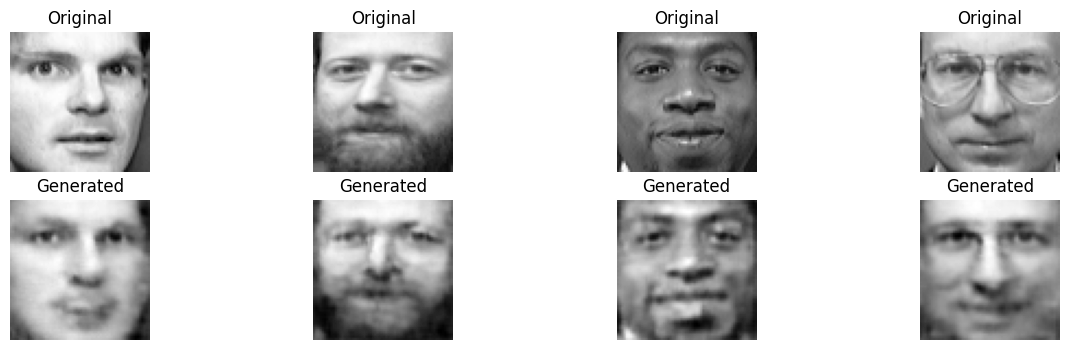

In [48]:
# TEST_CELL
train_images, test_images = train_test_split(X,
                                              test_size=0.01,
                                              random_state=42)
reconstructed_faces = reconstruct_faces(encoder_test,
                                   decoder_test,
                                   test_image=test_images)
fig, axes = plt.subplots(2, 4, figsize=(15, 4))

for i in range(4):
    axes[0, i].imshow((test_images[i]), cmap='gray')
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")
    axes[1, i].imshow((reconstructed_faces[i].numpy()), cmap='gray')
    axes[1, i].axis("off")
    axes[1, i].set_title("Generated")

plt.show()

**Salida esperada**:
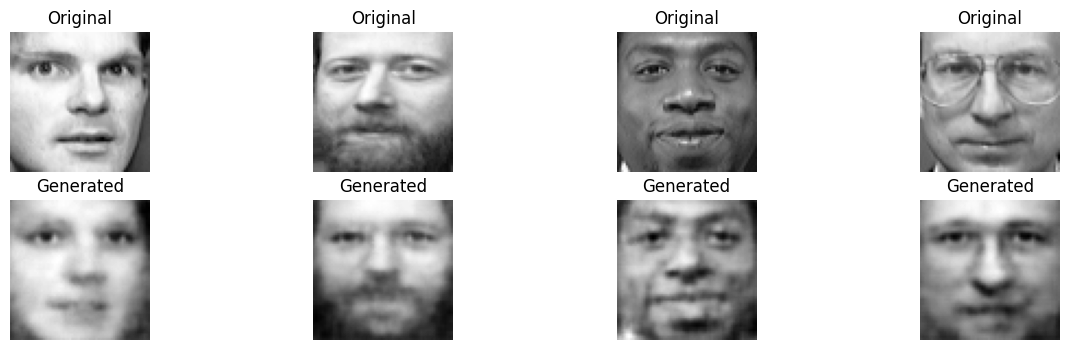

> **Nota**: las imágenes de la salida anterior pueden variar ligermente.

### **Evaluar código**

In [ ]:
grader.run_test("Test 6_1", globals())

Test 6_1


In [ ]:
grader.run_test("Test 6_2", globals())

Test 6_2


# **7. Interpolación de rostros**
---
Vamos a hacer una transformación entre caras. Complete la función `face_interpolation`, que realiza una interpolación de caras utilizando un modelo de _autoencoder_ variacional. La función debe recibir como entrada un codificador, un decodificador, dos caras y el número de pasos de interpolación, y luego utilizarlos para realizar la interpolación de caras, es decir, mostrar los pasos de la transformación de una cara a otra.

**Entradas:**

* **`encoder`**: una instancia del codificador tipo `tf.keras.Model`.
* **`decoder`**: una instancia del decodificador tipo `tf.keras.Model`.
* **`face1`**: una cara tipo `tf.Tensor`.
* **`face2`**: una cara tipo `tf.Tensor`.
* **`num_steps`**: el número de pasos de interpolación tipo `int`.

**Salida:**

* **`faces`**: `list`, una lista de tamaño `num_steps`, de caras interpoladas entre `face1`y `face2`, cada una tipo `tf.Tensor`.

> **Notas**:
  * Para lograr la interpolación, codifique las caras `face1` y `face2` para calcular la media y desviación latente de cada una. Como vimos en el ejercicio anterior, a partir de la media y desviación se puede reconstruir la imagen original.
  * Sean entonces `z_mean_1`, `z_mean_2` y `z_log_var_1`, `z_log_var_2` las medias y desviaciones de `face1` y `face2` respectivamente. Los pasos de la interpolación se logran reconstruyendo caras a partir de la interpolación lineal entre `z_mean_1` y `z_mean_2` y entre `z_log_var_1`, `z_log_var_2`.
  * La interpolación lineal (o combinación lineal convexa) entre `z_mean_1` ($z_{\mu1}$) y `z_mean_2` ($z_{\mu2}$) está compuesta por el conjunto $\{z_{\mu1}\cdot(1-\alpha)+z_{\mu2}\cdot\alpha ; \forall\alpha \in [0,1] \}$. Algo análogo sucede para `z_log_var_1` y `z_log_var_2`.
  *  Usted debe escoger un número `num_steps` de parejas (`z_mean_i`, `z_log_var_i`) uniformemente distribuidos sobre la interpolación lineal entre  `z_mean_1` y `z_mean_2`, y entre `z_log_var_1`, `z_log_var_2`, y a partir de cada pareja (`z_mean_i`, `z_log_var_i`) debe hacer la reconstrucción de correspondiente.
  * Puede usar la función `np.linspace()` para escoger esos `num_steps` puntos.
  * Cada rostro reconstruido lo debe ir guardando en la lista que finalmente retorna la función.

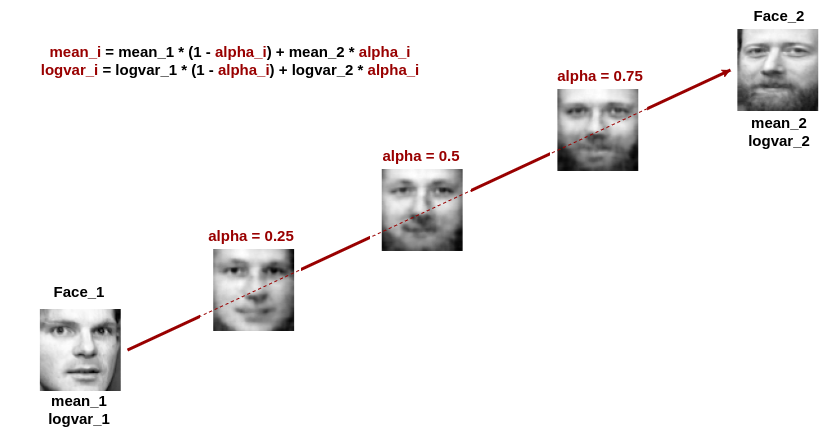

In [49]:
# FUNCIÓN CALIFICADA face_interpolation
def face_interpolation(encoder, decoder, face1, face2, num_steps=10):

    # Asegurarse de que face1 y face2 son tensores de tamaño [1, 64, 64, 1]
    face1 = tf.expand_dims(face1, axis=-1)
    face2 = tf.expand_dims(face2, axis=-1)

    face1 = tf.expand_dims(face1, axis=0)
    face2 = tf.expand_dims(face2, axis=0)

    # Codificar ambas caras para obtener los parámetros latentes
    z_mean_1, z_log_var_1 = encoder(face1)
    z_mean_2, z_log_var_2 = encoder(face2)

    # Generando valore alpha
    alphas = np.linspace(0, 1, num_steps)

    # Lista para almacenar las caras interpoladas
    faces = []

    # Interpolación lineal entre los parámetros latentes de face1 y face2
    for alpha in alphas:
        # Interpolación entre medias y log-varianzas
        z_mean_i = (1 - alpha) * z_mean_1 + alpha * z_mean_2
        z_log_var_i = (1 - alpha) * z_log_var_1 + alpha * z_log_var_2

        # Reparameterización para obtener z_i
        z_i = reparameterize(z_mean_i, z_log_var_i)

        # Reconstruccion
        reconstructed_face = decoder(z_i)

        # Añadir la cara reconstruida a la lista
        faces.append(tf.squeeze(reconstructed_face))

        # Para asegurar que la salida esté en el rango [0, 1]
        reconstructed_face = tf.sigmoid(reconstructed_face)

        # Aseguramos que la imagen tenga la forma (64, 64, 1)
        reconstructed_face = tf.squeeze(reconstructed_face, axis=0)  # Elimina la dimensión del batch

        # Guardamos la cara interpolada en la lista
        faces.append(reconstructed_face)

    return faces

IndexError: index 12 is out of bounds for axis 0 with size 12

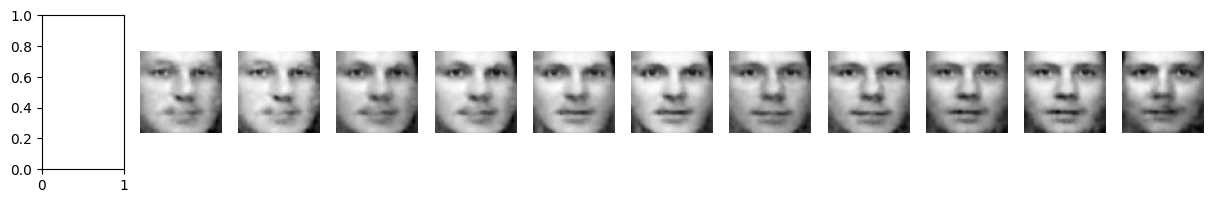

In [50]:
# TEST_CELL
num_steps = 10
faces = face_interpolation(encoder_test,
                   decoder_test,
                   test_images[0],
                   test_images[1],
                   num_steps=num_steps)
fig, axes = plt.subplots(1, num_steps + 2, figsize=(15, 2))
for i, interpolated_face in enumerate(faces):
    axes[i + 1].imshow(interpolated_face.numpy(), cmap='gray')
    axes[i + 1].axis("off")
axes[0].imshow(test_images[0], cmap='gray')
axes[0].axis("off")
axes[num_steps + 1].imshow(test_images[1], cmap='gray')
axes[num_steps + 1].axis("off")
plt.show()

**Salida esperada**:
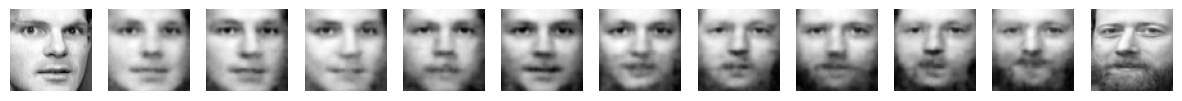

> **Nota**: las imágenes de la salida anterior pueden variar ligermente debido al componente aleatorio del muestreo al momento de hacer la generación.

Hemos terminado ¡Buen trabajo!

### **Evaluar código**

In [ ]:
grader.run_test("Test 7_1", globals())

Test 7_1


In [ ]:
grader.run_test("Test 7_2", globals())

Test 7_2


# **Evaluación**

> Tiempo estimado: 17:00 m sin GPU, 2:30 m con GPU

In [51]:
grader.submit_task(globals())

Test 1_1
Test 1_2
Test 2_1
Test 2_2
Test 3_1
Test 3_2
Test 4_1
Test 4_2
Test 5_1
Test 6_1
Test 6_2
Test 7_1
Test 7_2


# **Referencias**
---
* The Olivetti faces dataset: https://scikit-learn.org/0.19/datasets/olivetti_faces.html
* TensorFlow: Codificador automático variacional convolucional https://www.tensorflow.org/tutorials/generative/cvae?hl=es-419

# **Créditos**
---

* **Profesor:** [Fabio Augusto Gonzalez](https://dis.unal.edu.co/~fgonza/)
* **Asistentes docentes :**
  * [Santiago Toledo Cortés](https://sites.google.com/unal.edu.co/santiagotoledo-cortes/)
* **Diseño de imágenes:**
    - [Mario Andres Rodriguez Triana](mailto:mrodrigueztr@unal.edu.co).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*